
###Team name: Sabudana
###Team size: 2
###Track: 3
###Dataset used: [link](https://www.kaggle.com/datasets/arjunprasadsarkhel/2021-olympics-in-tokyo?resource=download)


In [ ]:
# importing necessary libraries.
import pandas as pd
import numpy as np
from scipy.stats import shapiro

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


import warnings

# setting pd.options to see all the rows and columns and ignore the warnings
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

In [ ]:
# loading the datasets
Athletes=pd.read_excel("/content/Athletes.xlsx")
Coaches=pd.read_excel("/content/Coaches.xlsx")
EntriesGender=pd.read_excel("/content/EntriesGender.xlsx")
Medals=pd.read_excel("/content/Medals.xlsx")
Teams=pd.read_excel("/content/Teams.xlsx")

In [ ]:
Athletes.head()

,Name,NOC,Discipline
0,AALERUD Katrine,Norway,Cycling Road
1,ABAD Nestor,Spain,Artistic Gymnastics
2,ABAGNALE Giovanni,Italy,Rowing
3,ABALDE Alberto,Spain,Basketball
4,ABALDE Tamara,Spain,Basketball


In [ ]:
Coaches.head()

,Name,NOC,Discipline,Event
0,ABDELMAGID Wael,Egypt,Football,NaN
1,ABE Junya,Japan,Volleyball,NaN
2,ABE Katsuhiko,Japan,Basketball,NaN
3,ADAMA Cherif,Côte d'Ivoire,Football,NaN
4,AGEBA Yuya,Japan,Volleyball,NaN


In [ ]:
EntriesGender.head()

,Discipline,Female,Male,Total
0,3x3 Basketball,32,32,64
1,Archery,64,64,128
2,Artistic Gymnastics,98,98,196
3,Artistic Swimming,105,0,105
4,Athletics,969,1072,2041


In [ ]:
Medals.head()

,Rank,Team/NOC,Gold,Silver,Bronze,Total,Rank by Total
0,1,United States of America,39,41,33,113,1
1,2,People's Republic of China,38,32,18,88,2
2,3,Japan,27,14,17,58,5
3,4,Great Britain,22,21,22,65,4
4,5,ROC,20,28,23,71,3


In [ ]:
Teams.head()

,Name,Discipline,NOC,Event
0,Belgium,3x3 Basketball,Belgium,Men
1,China,3x3 Basketball,People's Republic of China,Men
2,China,3x3 Basketball,People's Republic of China,Women
3,France,3x3 Basketball,France,Women
4,Italy,3x3 Basketball,Italy,Women


In [ ]:
print(Athletes.isnull().sum().any())
print(Coaches.isnull().sum().any())
print(EntriesGender.isnull().sum().any())
print(Medals.isnull().sum().any())
print(Teams.isnull().sum().any())

False
True
False
False
False


##### **Inference:**
Only the dataset Coaches contains null values.

We choose to merge Medals and EntriesGender with Atheletes since, we are planning to predict the Rank by Total from the Medals dataset, and data like the number of male and female participantsfrom each country na dthe discipline are important data.

In [ ]:
Athletes.drop(["Name"],axis=1,inplace=True)
Athletes = Athletes.drop_duplicates()

##### The major duplicates were unique due to the name column only. Once we removed the name column (which is insignificant for our prediction), we got a ton of duplicate values

**Merging the datasets Atheletes, Medals and EntriesGender**

##### Merging the datasets Atheletes, Medals

In [ ]:
Medals.columns

Index(['Rank', 'Team/NOC', 'Gold', 'Silver', 'Bronze', 'Total',
       'Rank by Total'],
      dtype='object')

In [ ]:
# creating new columns and inserting values( initially as 0s)
Athletes["Gold"]= 0
Athletes["Silver"]= 0
Athletes["Bronze"]= 0
Athletes["Total"]= 0
Athletes["Rank by Total"]=0

In [ ]:
# filling the values for respective columns in Athletes dataset
for i in Athletes["NOC"]:

    val=len(Medals[Medals["Team/NOC"]==i]["Team/NOC"])
    if val!=0:

        Athletes.loc[Athletes["NOC"] == i, "Gold"] = list(Medals[Medals["Team/NOC"]==i]["Gold"])[0]
        Athletes.loc[Athletes["NOC"] == i, "Silver"] = list(Medals[Medals["Team/NOC"]==i]["Silver"])[0]
        Athletes.loc[Athletes["NOC"] == i, "Bronze"] = list(Medals[Medals["Team/NOC"]==i]["Bronze"])[0]
        Athletes.loc[Athletes["NOC"] == i, "Total"] = list(Medals[Medals["Team/NOC"]==i]["Total"])[0]
        Athletes.loc[Athletes["NOC"] == i, "Rank by Total"] = list(Medals[Medals["Team/NOC"]==i]["Rank by Total"])[0]
    else:
        Athletes.loc[Athletes["NOC"] == i, "Gold"] = 0
        Athletes.loc[Athletes["NOC"] == i, "Silver"] = 0
        Athletes.loc[Athletes["NOC"] == i, "Bronze"] = 0
        Athletes.loc[Athletes["NOC"] == i, "Total"] = 0
        Athletes.loc[Athletes["NOC"] == i, "Rank by Total"] = 0

In [ ]:
Athletes.head()

,NOC,Discipline,Gold,Silver,Bronze,Total,Rank by Total
0,Norway,Cycling Road,4,2,2,8,29
1,Spain,Artistic Gymnastics,3,8,6,17,17
2,Italy,Rowing,10,10,20,40,7
3,Spain,Basketball,3,8,6,17,17
5,France,Handball,10,12,11,33,10


##### Merge Athletes and EntriesGender

In [ ]:
EntriesGender.head()

,Discipline,Female,Male,Total
0,3x3 Basketball,32,32,64
1,Archery,64,64,128
2,Artistic Gymnastics,98,98,196
3,Artistic Swimming,105,0,105
4,Athletics,969,1072,2041


In [ ]:
Athletes.head()

,NOC,Discipline,Gold,Silver,Bronze,Total,Rank by Total
0,Norway,Cycling Road,4,2,2,8,29
1,Spain,Artistic Gymnastics,3,8,6,17,17
2,Italy,Rowing,10,10,20,40,7
3,Spain,Basketball,3,8,6,17,17
5,France,Handball,10,12,11,33,10


In [ ]:
# checking if the same Disciplines are there in both the datasets
for i in EntriesGender["Discipline"].unique():
    if i not in Athletes["Discipline"].unique():
        print(i)

In [ ]:
# creating new columns
Athletes["Female"]=0
Athletes["Male"]=0

In [ ]:
Athletes.head()


,NOC,Discipline,Gold,Silver,Bronze,Total,Rank by Total,Female,Male
0,Norway,Cycling Road,4,2,2,8,29,0,0
1,Spain,Artistic Gymnastics,3,8,6,17,17,0,0
2,Italy,Rowing,10,10,20,40,7,0,0
3,Spain,Basketball,3,8,6,17,17,0,0
5,France,Handball,10,12,11,33,10,0,0


In [ ]:
# filling the values for respective columns in Athletes dataset
for i in EntriesGender["Discipline"]:
    Athletes.loc[Athletes["Discipline"] == i, "Female"] = list(EntriesGender[EntriesGender["Discipline"]==i]["Female"])[0]
    Athletes.loc[Athletes["Discipline"] == i, "Male"] = list(EntriesGender[EntriesGender["Discipline"]==i]["Male"])[0]


In [ ]:
Athletes.head()

,NOC,Discipline,Gold,Silver,Bronze,Total,Rank by Total,Female,Male
0,Norway,Cycling Road,4,2,2,8,29,70,131
1,Spain,Artistic Gymnastics,3,8,6,17,17,98,98
2,Italy,Rowing,10,10,20,40,7,257,265
3,Spain,Basketball,3,8,6,17,17,144,144
5,France,Handball,10,12,11,33,10,168,168


In [ ]:
Athletes.shape

(2112, 9)

In [ ]:
# saving the dataset for future use
Athletes.to_csv("Athletes_new.csv")

**Data Analysis**

In [ ]:
# loading the dataset
Athletes=pd.read_csv("/content/Athletes_new.csv")

In [ ]:
Athletes.head()

,Unnamed: 0,NOC,Discipline,Gold,Silver,Bronze,Total,Rank by Total,Female,Male
0,0,Norway,Cycling Road,4,2,2,8,29,70,131
1,1,Spain,Artistic Gymnastics,3,8,6,17,17,98,98
2,2,Italy,Rowing,10,10,20,40,7,257,265
3,3,Spain,Basketball,3,8,6,17,17,144,144
4,5,France,Handball,10,12,11,33,10,168,168


In [ ]:
Athletes.drop("Unnamed: 0", axis=1,inplace=True)

In [ ]:
# performing the Shapiro-Wilk Test (a statistical hypothesis test used to assess whether a sample of data is likely to have come from a normally distributed population.)
def one_sample(column):
  h0="The data is normally distributed"
  h1="The data is not normally distributed"


  data=Athletes[column]
  stat,p=shapiro(data)

  if p>0.05 :
    print(h0)
  elif p< 0.05 and stat>0.90:
    print(h1+" but the distribution is very close to a normal distribution")

  else:
    print(h1,f", the stats values is: {stat:.2f}")

In [ ]:
def hist(col):
  fig = px.histogram(Athletes, x=col,  title=f"Distribution of {col}")

  fig.update_layout(xaxis_title=f"Count of {col}",yaxis_title="Count")


  fig.show()
  one_sample(col)

In [ ]:
Athletes.head()

,Unnamed: 0,NOC,Discipline,Gold,Silver,Bronze,Total,Rank by Total,Female,Male
0,0,Norway,Cycling Road,4,2,2,8,29,70,131
1,1,Spain,Artistic Gymnastics,3,8,6,17,17,98,98
2,2,Italy,Rowing,10,10,20,40,7,257,265
3,3,Spain,Basketball,3,8,6,17,17,144,144
4,5,France,Handball,10,12,11,33,10,168,168


In [ ]:
hist("Total")

The data is not normally distributed , the stats values is: 0.67


##### **Inference:**
##### As seen from the histogram, the data is not normally distributed, leading to the observed gaps and discrete nature of the histogram.
##### Maximum countries have bagged the medals from 0-4 medal counts.
##### The maximum number of medals is bagged by United States of America (113).

In [ ]:
px.box(Athletes, y="Total", title="Box Plot of Total")

##### **Inference:**

##### Boxplot shows some outliers, but we need not handle the outliers as they aren't outliers actually. The column contains the summation of total number of medals, which ofcourse can contain values at the higher end like 113.

In [ ]:
px.bar(Athletes, x="Gold", y="Gold",color="NOC", title="Bar plot of Gold and NOC")

##### **Inference:**

##### Maximum gold medals bagged is 39 by United States of America.

In [ ]:
px.bar(Athletes, x="Silver", y="Silver",color="NOC", title="Bar plot of Silver and NOC")

##### **Inference:**

##### Maximum silver medals bagged is 41 by United States of America.

In [ ]:
Athletes["Silver"].nunique()

17

In [ ]:
px.bar(Athletes, x="Bronze", y="Bronze",color="NOC", title="Bar plot of Bronze and NOC")

##### **Inference:**

##### Maximum bronze medals bagged is 33 by United States of America, as seen from the bar plot.

In [ ]:
px.bar(Athletes, x="Rank by Total", y="Rank by Total",color="NOC", title="Bar plot of Rank by Total and NOC")

##### **Inference:**
##### There are 17 countries which are ranked highest (77) which includes countries like Republic of Moldova, Namibia, Grenada

In [ ]:
sorted_df = Athletes.sort_values(by="Female", ascending=False)
females=sorted_df[["Female","NOC"]].head(3)



px.pie(females, values="Female", names="NOC", title="Piechart for the top 3 countries with most female atheletes")


##### **Inference:**
##### The top 3 countries with most number of female participants are Chile, Slovenia and Yemen with 969 females each

In [ ]:
sorted_df = Athletes.sort_values(by="Male", ascending=False)
males=sorted_df[["Male","NOC"]].head(3)
px.pie(males, values="Male", names="NOC", title="Piechart for the top 3 countries with most male atheletes")


##### **Inference:**
##### The top 3 countries with most number of male  participants are Guinea-Bissau, Sweden and Botswana with 1072 males each

In [ ]:
sorted_df = Athletes.sort_values(by="Female", ascending=True)
females=sorted_df[["Female","NOC"]].head(3)
px.pie(females, values="Female", names="NOC", title="Piechart for the top 3 countries with least number of female atheletes")



##### **Inference:**
##### The top 3 countries with least number of female participants are Venezuela, Chile and Germany with 10 females each

In [ ]:
sorted_df = Athletes.sort_values(by="Male", ascending=True)
males=sorted_df[["Male","NOC","Discipline"]].head(3)
males.head()

,Male,NOC,Discipline
933,0,United States of America,Rhythmic Gymnastics
1183,0,People's Republic of China,Artistic Swimming
739,0,Australia,Artistic Swimming


##### **Inference:**
##### There least number of male athletes were for United States of America, People's Republic of China, Australia (considering 3)

In [ ]:
Athletes.head()

,NOC,Discipline,Gold,Silver,Bronze,Total,Rank by Total,Female,Male
0,Norway,Cycling Road,4,2,2,8,29,70,131
1,Spain,Artistic Gymnastics,3,8,6,17,17,98,98
2,Italy,Rowing,10,10,20,40,7,257,265
3,Spain,Basketball,3,8,6,17,17,144,144
4,France,Handball,10,12,11,33,10,168,168


In [ ]:
# fetching the columns with numbers for correlation

numeric_df=Athletes.select_dtypes(include=np.number)
numeric_df.head()

,Gold,Silver,Bronze,Total,Rank by Total,Female,Male
0,4,2,2,8,29,70,131
1,3,8,6,17,17,98,98
2,10,10,20,40,7,257,265
3,3,8,6,17,17,144,144
4,10,12,11,33,10,168,168


In [ ]:
# printing the correlation values
Athletes.corr(numeric_only=True)

,Gold,Silver,Bronze,Total,Rank by Total,Female,Male
Gold,1.000000,0.938294,0.877678,0.975036,-0.354421,-0.173461,-0.179603
Silver,0.938294,1.000000,0.877201,0.973459,-0.345099,-0.176197,-0.182126
Bronze,0.877678,0.877201,1.000000,0.947149,-0.379112,-0.216763,-0.224087
Total,0.975036,0.973459,0.947149,1.000000,-0.371479,-0.194231,-0.200889
Rank by Total,-0.354421,-0.345099,-0.379112,-0.371479,1.000000,-0.061698,-0.057462
Female,-0.173461,-0.176197,-0.216763,-0.194231,-0.061698,1.000000,0.994241
Male,-0.179603,-0.182126,-0.224087,-0.200889,-0.057462,0.994241,1.000000


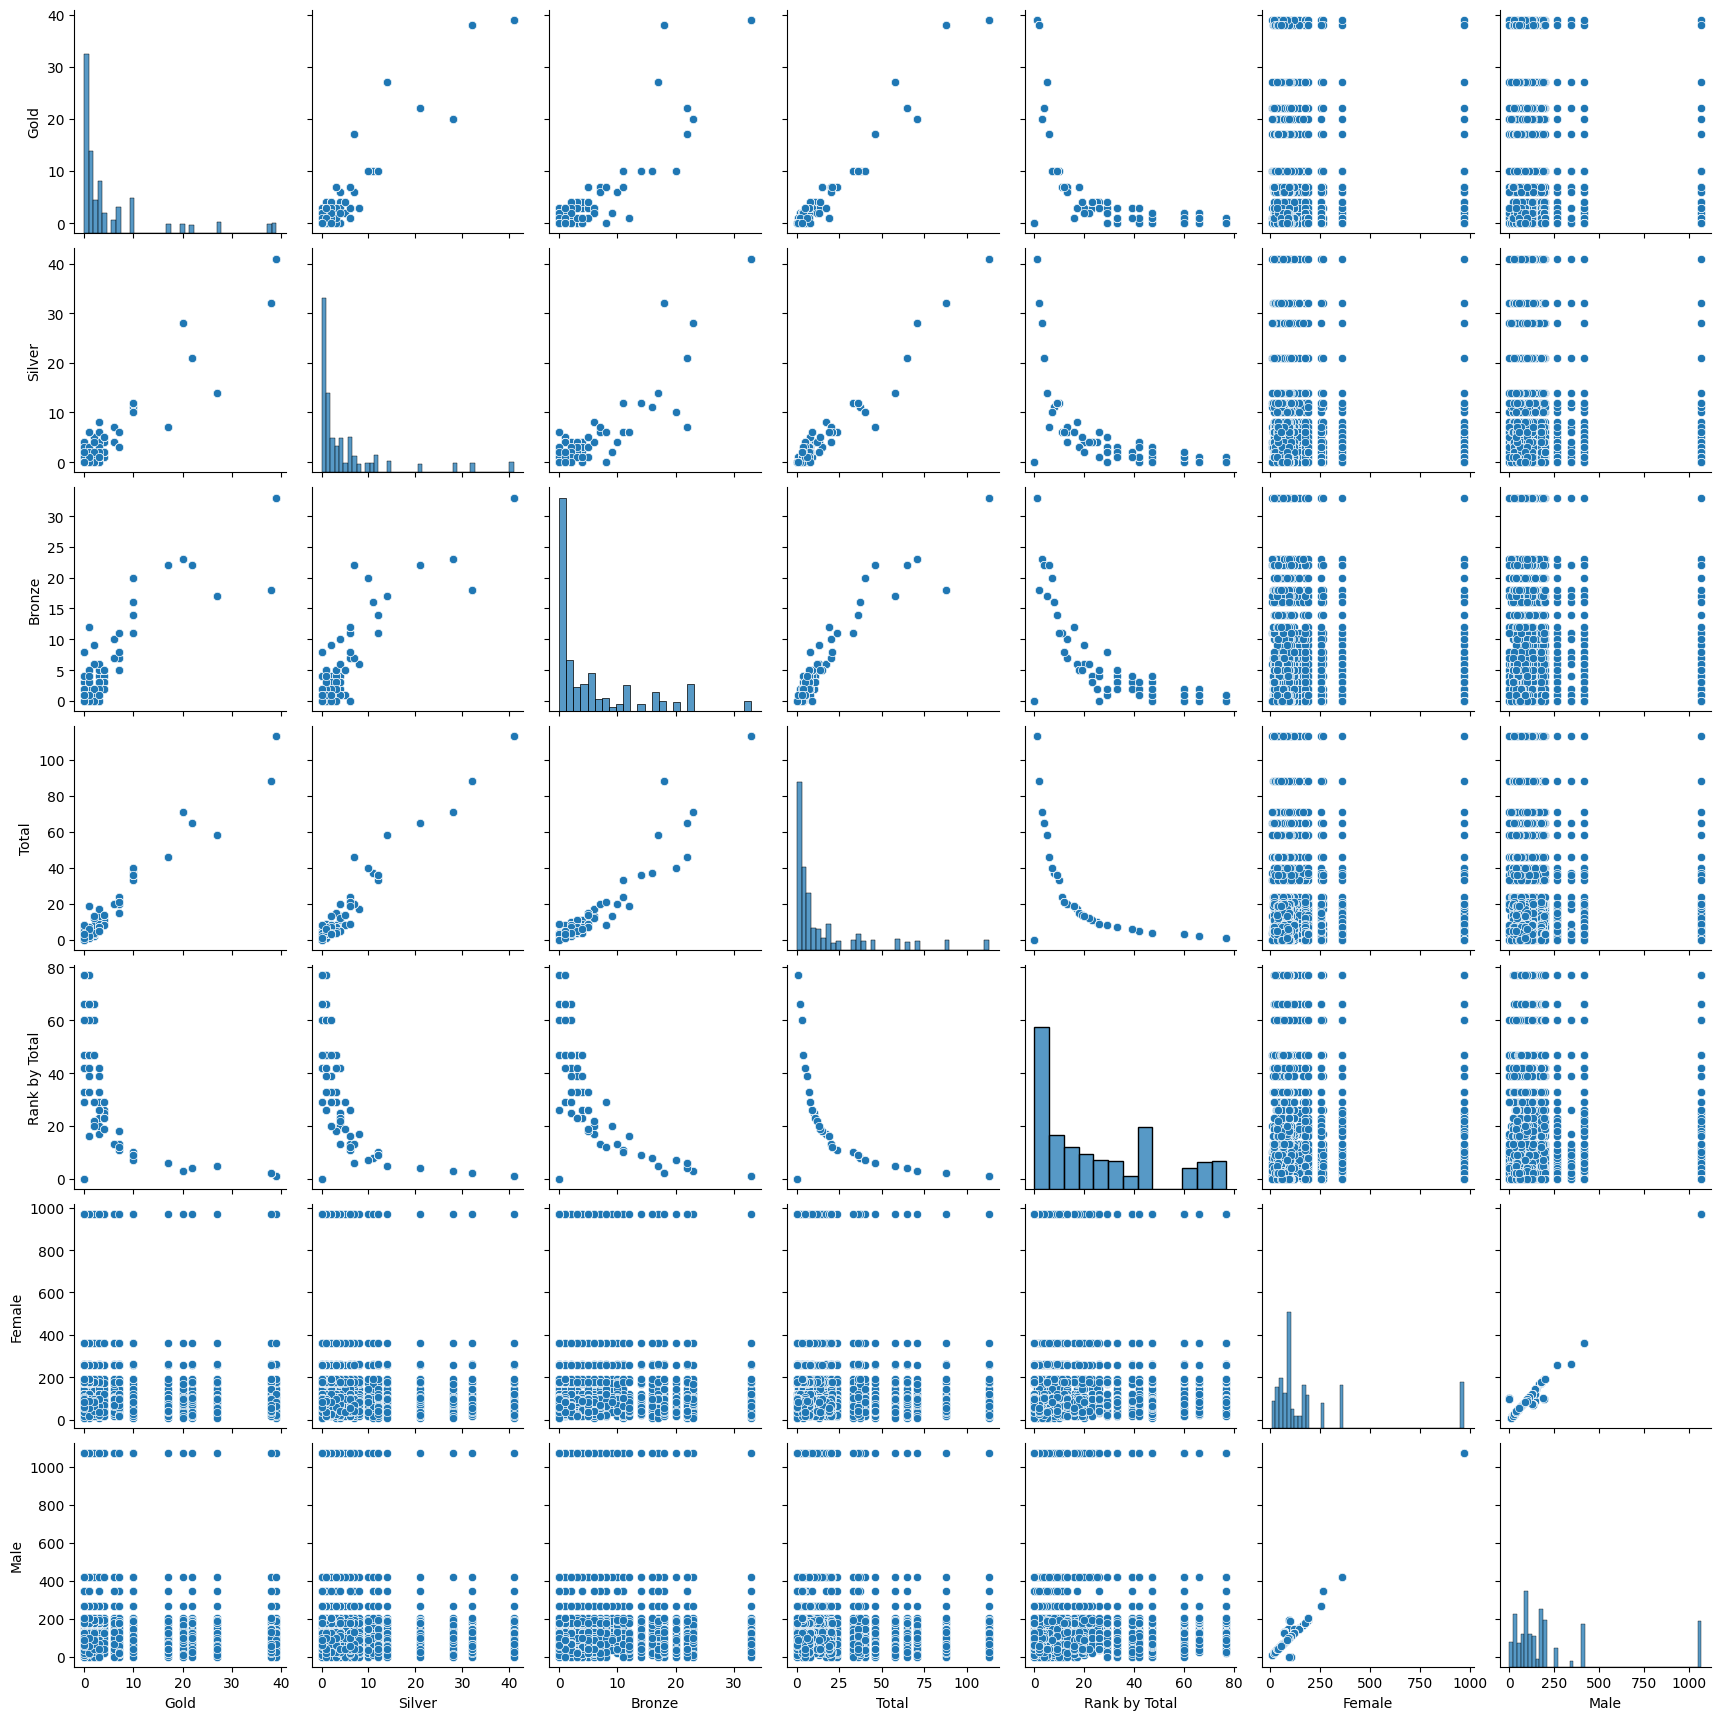

In [ ]:
# printing the correlation plots
sns.pairplot(numeric_df)

##### **Inference:**
##### Gold has high positive correlation with Silver and Bronze, Male has high correlation with Female. Total also has high positive correlataion with Silver, Gold, Bronze

In [ ]:
Athletes.head()

,NOC,Discipline,Gold,Silver,Bronze,Total,Rank by Total,Female,Male
0,Norway,Cycling Road,4,2,2,8,29,70,131
1,Spain,Artistic Gymnastics,3,8,6,17,17,98,98
2,Italy,Rowing,10,10,20,40,7,257,265
3,Spain,Basketball,3,8,6,17,17,144,144
4,France,Handball,10,12,11,33,10,168,168


**Dropping the columns not needed**

In [ ]:
Athletes.drop(["NOC"], axis=1,inplace=True)

**Encoding Categorical variables**

In [ ]:
# unique_countries = Athletes['NOC'].unique()
# country_dict = {country: idx+1 for idx, country in enumerate(unique_countries)}
# Athletes['NOC_encoded'] = Athletes['NOC'].map(country_dict)

In [ ]:
Athletes.head()

,Discipline,Gold,Silver,Bronze,Total,Rank by Total,Female,Male
0,Cycling Road,4,2,2,8,29,70,131
1,Artistic Gymnastics,3,8,6,17,17,98,98
2,Rowing,10,10,20,40,7,257,265
3,Basketball,3,8,6,17,17,144,144
4,Handball,10,12,11,33,10,168,168


In [ ]:
unique_discipline = Athletes['Discipline'].unique()
discipline_dict = {dis: idx+1 for idx, dis in enumerate(unique_discipline)}
Athletes['Discipline_encoded'] = Athletes['Discipline'].map(discipline_dict)

In [ ]:
Athletes.head()

,Discipline,Gold,Silver,Bronze,Total,Rank by Total,Female,Male,Discipline_encoded
0,Cycling Road,4,2,2,8,29,70,131,1
1,Artistic Gymnastics,3,8,6,17,17,98,98,2
2,Rowing,10,10,20,40,7,257,265,3
3,Basketball,3,8,6,17,17,144,144,4
4,Handball,10,12,11,33,10,168,168,5


In [ ]:
#removing the origninal column after encoding
Athletes.drop(["Discipline"],axis=1,inplace=True)

In [ ]:
Athletes.head()

,Gold,Silver,Bronze,Total,Rank by Total,Female,Male,Discipline_encoded
0,4,2,2,8,29,70,131,1
1,3,8,6,17,17,98,98,2
2,10,10,20,40,7,257,265,3
3,3,8,6,17,17,144,144,4
4,10,12,11,33,10,168,168,5


In [ ]:
discipline_dict

{'Cycling Road': 1,
 'Artistic Gymnastics': 2,
 'Rowing': 3,
 'Basketball': 4,
 'Handball': 5,
 'Swimming': 6,
 'Karate': 7,
 'Wrestling': 8,
 'Rhythmic Gymnastics': 9,
 'Baseball/Softball': 10,
 'Athletics': 11,
 'Artistic Swimming': 12,
 'Judo': 13,
 'Shooting': 14,
 'Table Tennis': 15,
 'Football': 16,
 'Taekwondo': 17,
 'Fencing': 18,
 'Badminton': 19,
 'Boxing': 20,
 'Weightlifting': 21,
 'Archery': 22,
 'Diving': 23,
 'Beach Volleyball': 24,
 'Sailing': 25,
 'Hockey': 26,
 'Trampoline Gymnastics': 27,
 'Marathon Swimming': 28,
 'Triathlon': 29,
 'Canoe Slalom': 30,
 'Water Polo': 31,
 'Surfing': 32,
 'Canoe Sprint': 33,
 'Cycling BMX Racing': 34,
 'Rugby Sevens': 35,
 'Volleyball': 36,
 'Equestrian': 37,
 'Tennis': 38,
 'Cycling Track': 39,
 'Golf': 40,
 'Skateboarding': 41,
 'Modern Pentathlon': 42,
 'Cycling Mountain Bike': 43,
 '3x3 Basketball': 44,
 'Cycling BMX Freestyle': 45,
 'Sport Climbing': 46}

In [ ]:
# dividing into X and y
X = Athletes.drop('Rank by Total', axis=1)
y = Athletes['Rank by Total']

# Using SMOTE for oversampling since there was class imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)


# doing the train test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2)

In [ ]:
len(y_resampled)

14849

In [ ]:
nb_model = MultinomialNB()

nb_model.fit(X_train, y_train)

y_pred = nb_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.20976430976430976


In [ ]:
lr_model = LogisticRegression(multi_class='multinomial', solver='lbfgs')

lr_model.fit(X_train, y_train)

y_pred = lr_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.42794612794612796


In [ ]:
# creating one hot encodings
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
y_train_categorical = to_categorical(y_train_encoded)
y_test_categorical = to_categorical(y_test_encoded)

# defining the ANN model
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(32, activation='relu'))
model.add(Dense(y_train_categorical.shape[1], activation='softmax'))  # Output layer with softmax for multiclass

# compiling the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# training the model
history=model.fit(X_train, y_train_categorical, epochs=20, batch_size=32, validation_data=(X_test, y_test_categorical))

# evaluating the model
_, accuracy = model.evaluate(X_test, y_test_categorical)
print("Accuracy:", accuracy)

Epoch 1/20
372/372 [==============================] - 3s 6ms/step - loss: 4.8294 - accuracy: 0.0975 - val_loss: 2.8314 - val_accuracy: 0.1801
Epoch 2/20
372/372 [==============================] - 1s 2ms/step - loss: 2.3533 - accuracy: 0.2742 - val_loss: 2.0382 - val_accuracy: 0.3508
Epoch 3/20
372/372 [==============================] - 1s 2ms/step - loss: 1.7667 - accuracy: 0.4271 - val_loss: 1.5367 - val_accuracy: 0.4680
Epoch 4/20
372/372 [==============================] - 1s 2ms/step - loss: 1.3780 - accuracy: 0.5373 - val_loss: 1.2492 - val_accuracy: 0.5805
Epoch 5/20
372/372 [==============================] - 1s 2ms/step - loss: 1.1599 - accuracy: 0.6066 - val_loss: 1.1128 - val_accuracy: 0.6118
Epoch 6/20
372/372 [==============================] - 1s 2ms/step - loss: 1.0400 - accuracy: 0.6501 - val_loss: 1.0565 - val_accuracy: 0.6209
Epoch 7/20
372/372 [==============================] - 1s 2ms/step - loss: 0.9641 - accuracy: 0.6772 - val_loss: 0.9673 - val_accuracy: 0.6653
Epoch 

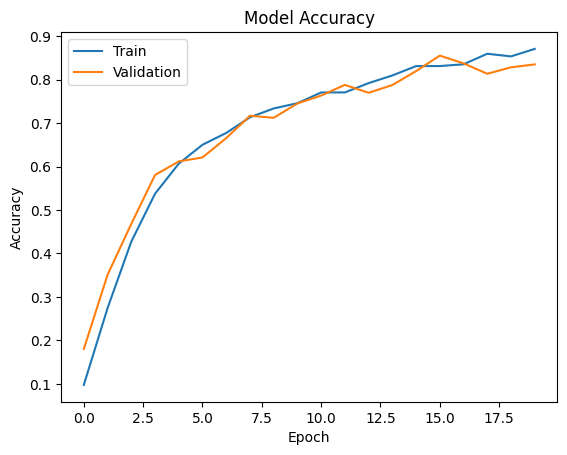

In [ ]:
# plotting the accuracy curve
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

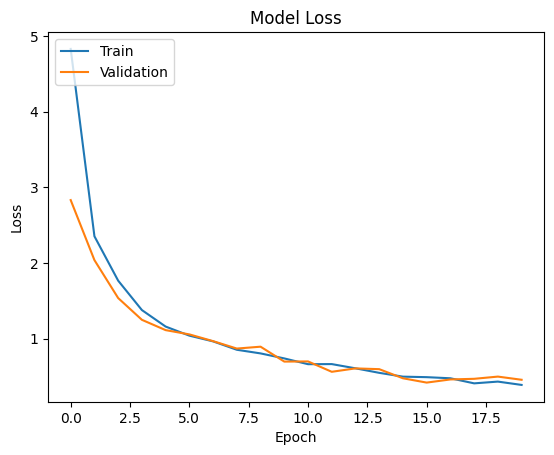

In [ ]:
# plotting the loss curve
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# saving the model for future use
# model.save('ann.h5')

In [ ]:
# etting the test accuracy
y_pred_probs = model.predict(X_test)
y_pred = y_pred_probs.argmax(axis=1)

accuracy = accuracy_score(y_test_encoded, y_pred)
print("Accuracy:", accuracy)

93/93 [==============================] - 0s 2ms/step
Accuracy: 0.835016835016835
